In [155]:
import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

# Data preprocessing and feature selections

## Data preprocessing

#For this to work, the data folder needs to be one level above the project folder and the folder name needs
#to be 'data'
data_folder = '../data/'
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data(data_folder)


In [3]:
np.random.seed(0)

In [4]:
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

KeyboardInterrupt: 

In [4]:
np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [5]:
x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [6]:
#features_named all the features names and remove the ID column
features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 
features_name

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES',
       'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1',
       'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE',
       'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH',
       'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS',
       'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW',
       'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2',
       'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA',
       'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3',
       'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3',
       'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK',
       'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2',
       'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5',
    

## Feature selection

one paper on internet suggests to use these features : 

 _RFHYPE5, TOLDHI2, _CHOLCHK, _BMI5, SMOKE100, CVDSTRK3, DIABETE3, _TOTINDA, _FRTLT1, _VEGLT1, _RFDRHV5, HLTHPLN1, MEDCOST, GENHLTH, MENTHLTH, PHYSHLTH, DIFFWALK, SEX, _AGEG5YR, EDUCA, and INCOME2

We apply a mask to get only these important features.

Then using we use our preprocessing function. For feature where the answer is yes or no we make the data binary, ordinal (categorical) variables ares changed to 0,1,2,...,Missing values are replace by the mean of the column.


In [7]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2']


In [81]:
trainMask, testMask = masking((x_train, x_test), features_name, features_list)
trainProcessed = d.feature_processing_test(trainMask)

#Test data Processing 
testProcessed  = d.feature_processing_test(testMask)

x_train_algo = f.replaceMissingValuesMean(trainProcessed)
x_test_algo = f.replaceMissingValuesMean(testProcessed)
print(x_train_algo[:,19])
print(len(x_train_algo))
print(len(features_list))


[0.         0.20628162 0.         ... 1.         1.         0.        ]
328135
21


In [166]:
##test chelou
#x1_stand=f.standardize(x_train_algo)
x_train_stand=np.ones(x_train_algo.shape)
x_test_stand=np.ones(x_test_algo.shape)

x_trai_stand=f.standardize(x_train_algo)

for i in range(len(features_list)):
  x_train_stand[i]=f.standardize(x_train_algo[i])
  x_test_stand[i]=f.standardize(x_test_algo[i])

print(x_trai_stand==x_train_stand)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


# Processing 

### Now that the preprocessing has been done, we can format the data to be used by the algorithms

In [126]:
#tX_train = np.c_[np.ones((len(x_train_algo), 1)), x_train_algo]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

tX_train = np.c_[np.ones((len(x_train_algo), 1)), x_train_stand]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_stand]

### Initialisation of set parameters

In [127]:
initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]
initial_w = np.ones(len(tX_train[0]))
max_iter = 500

### Separation of the dataset in a test/train set

In [128]:
tX_train_train = tX_train[:int(len(tX_train)*0.7)]
y_train_train = y_train[:int(len(tX_train)*0.7)]
tX_train_test = tX_train[int(len(tX_train)*0.7):]
y_train_test = y_train[int(len(tX_train)*0.7):]



## Plotting functions

In [129]:
def loss_progression(w):
    # Plot progression of the weights in function of the iteration and progression on the test set
    plt.figure(0)
    plt.plot(w)

## And then, we can run the algorithms

In [130]:
def plotLossMSE(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_mse(y, x, w))

    plt.figure(0)
    plt.semilogy(loss)
    plt.semilogy(loss_test_set)
    plt.show()


1. MSE gradient descent

In [131]:
#Compute gradient descent with MSE as loss function (see functions.py for the function)

w_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 10, 0.01)

Gradient Descent(9/10): Final loss=80.18464962588749


In [132]:
loss_test_set = []

for w in w_mse_gd:
    loss_test_set.append(f.compute_mse(y_train_test, tX_train_test, w))

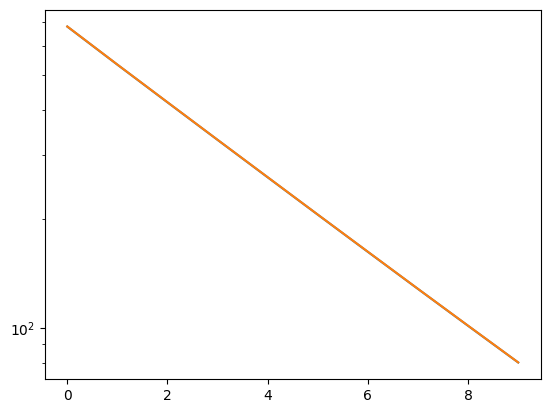

In [133]:
plt.figure(0)
plt.semilogy(loss_mse_gd)
plt.semilogy(loss_test_set)
plt.show()

In [101]:
y_pred = tX_train_test.dot(w_mse_gd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))
print("F1 score: ", f1)


Accuracy:  0.08906857914893185
F1 score:  0.16356835713419582


In [ ]:
#h.create_csv_submission(test_ids, y_test_rounded, 'submission_gd.csv')

In [102]:
#Test the model on the test sample. Do we need to standardize ?

y_test = tX_test.dot(w_mse_gd[-1])
y_test_rounded = np.where(y_test > 0, 1, -1) #not sure about this line

print('weights = \n\n', w_mse_gd[-1],'\n\n Loss = ', loss_mse_gd[-1],'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [0.04903566 0.04904174 0.04904589 0.04904809 0.04905119 0.04904731
 0.04904832 0.04904731 0.04904388 0.04904903 0.04903112 0.04902601
 0.04904714 0.04904906 0.04904871 0.04904793 0.04902131 0.04905031
 0.04904743 0.04905033 0.04905121 0.04905028] 

 Loss =  1.9711226851960524 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  1.0


Lets run some cross validation to see the best initial weights (as a function of the proportion of 1, -1 and 0)


2. MSE SGD

In [134]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train, tX_train, initial_w, 1000, 0.0001)

SGD iter. 999/999: loss=1.4592509266173614, w0=0.719923545336973, w1=0.2878646463939802


In [135]:
def plotLossMSE(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_mse(y, x, w))

    plt.figure(0)
    plt.semilogy(loss)
    plt.semilogy(loss_test_set)
    plt.show()


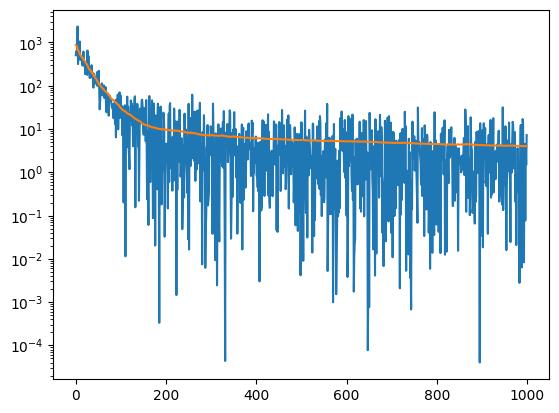

In [ ]:
plotLossMSE(w_mse_sgd, loss_mse_sgd, y_train_test, tX_train_test)

In [136]:
y_pred = tX_train_test.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.5044646031633161
F1 score:  0.06296701819089878


In [137]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

weights = 
 [ 0.71992355  0.28786465 -0.00861015 -0.07479877  0.96115535  0.76382322
  0.79952306  0.72310688  0.48449989  0.8248332  -0.35291523 -0.51265252
  0.74858723  0.80541539  0.77903047  0.78378034 -0.51029633  0.92194084
  0.73226863  0.86189295  0.92862269  0.92614267] 
 Loss =  1.4592509266173614 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.4414832828970826


3. Least squares

In [138]:
w_ls, loss_ls = f.least_squares(y_train, tX_train)

In [139]:
y_pred = tX_train_test.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.9117237736309058
F1 score:  0.036371701042359726


In [140]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-3.66067966e-01  5.75949422e-02  2.27764110e-03 -2.08810289e-04
 -2.93665345e-02 -6.61348331e-03 -9.02623972e-02 -3.72906967e-01
 -4.79531853e-02 -9.87913409e-02 -1.52569694e-03 -5.58292682e-03
 -9.86043000e-02 -4.21581421e-02 -7.34623468e-02  3.67252347e-02
  1.72571932e-02 -2.11669545e-01  3.33860048e-02 -6.21783788e-03
 -4.39318754e-03 -7.36295398e-03] 
 Loss =  0.13733121632804088 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.0026056189945053436


4. Ridge regression

In [141]:
w_ridge, loss_ridge = f.ridge_regression(y_train, tX_train, 0.01)

In [142]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-0.16807427  0.03917705  0.00263183 -0.00060332 -0.04608669 -0.03046109
 -0.09241493 -0.30090331 -0.06105668 -0.09886347 -0.01771055 -0.00968188
 -0.11182754 -0.0440128  -0.08040227  0.01886485  0.01556599 -0.07420305
 -0.02540871 -0.01530144 -0.01029129 -0.01434477] 
 Loss =  0.13792607978063323 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.001307380758646541


5. Logistic regression

In [143]:
y_train_processed_logreg = np.where(y_train == 1, 1, 0)
y_train_train_lg = np.where(y_train == 1, 1, 0)

In [144]:
w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train,np.ones(22),500, 0.1)

Gradient Descent(0/499): loss=22.228446953619866, w0=0.9088319282565185, w1=0.774423255619819
Gradient Descent(1/499): loss=9.611718774381371, w0=0.8176679123012238, w1=0.5488481612199283
Gradient Descent(2/499): loss=1.28687327883213, w0=0.7266558084004003, w1=0.323610439031915
Gradient Descent(3/499): loss=1.0905442714743465, w0=0.7117236550240043, w1=0.292093444421554
Gradient Descent(4/499): loss=1.0209680298350716, w0=0.7050843262580097, w1=0.28412996682435854
Gradient Descent(5/499): loss=0.9651266706147152, w0=0.6994541056665075, w1=0.2781157575578648
Gradient Descent(6/499): loss=0.9196805520798447, w0=0.6942399818510507, w1=0.27240817064918965
Gradient Descent(7/499): loss=0.8819683110273338, w0=0.6892627378443773, w1=0.2665683889722687
Gradient Descent(8/499): loss=0.8496157601200154, w0=0.6845022601659031, w1=0.2606701030212248
Gradient Descent(9/499): loss=0.8209881234992175, w0=0.6799539292963054, w1=0.2548381813401633
Gradient Descent(10/499): loss=0.7950910548661506, w0=

In [145]:
y_pred = tX_train_test.dot(w_logreg)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.9097733667882285
F1 score:  0.0506626763574177


In [146]:
y_test_logreg = tX_test.dot(w_logreg)
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg,'\n Loss = ', loss_logreg,'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

weights = 
 [ 0.05278194 -0.06642798  0.02117751 -0.00274513  0.49011676  0.18080126
 -0.32497592 -0.32600825 -0.52893756 -0.28400304 -0.42510498 -0.12187267
 -0.17498828 -0.1238623  -0.38370667  0.5267693   0.11758655  0.71558617
  0.07128298  0.13220975  0.25721627  0.26162381] 
 Loss =  0.2557907646635087 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.005704934219548543


In [117]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_processed_logreg, tX_train, 0.01, initial_w, 100, 0.1)

Gradient Descent(0/99): loss=18.207806990644862, w0=0.9078319282799385, w1=0.9078341834706829
Gradient Descent(1/99): loss=16.36117617190301, w0=0.8157561433011598, w1=0.815760581290357
Gradient Descent(2/99): loss=14.516392331053625, w0=0.7237725585933471, w1=0.7237791043345082
Gradient Descent(3/99): loss=12.67345441132835, w0=0.631881095434813, w1=0.6318896713945503
Gradient Descent(4/99): loss=10.832366467881576, w0=0.5400817347412534, w1=0.5400922610999396
Gradient Descent(5/99): loss=8.99317095889692, w0=0.4483749079165405, w1=0.44838730280129574
Gradient Descent(6/99): loss=7.156198218760744, w0=0.35676443230285565, w1=0.35677861205126216
Gradient Descent(7/99): loss=5.323926978543616, w0=0.26527949655879657, w1=0.26529537601322084
Gradient Descent(8/99): loss=3.5145487817161682, w0=0.17413819403247968, w1=0.17415568688197136
Gradient Descent(9/99): loss=1.8472306256148947, w0=0.0849185676753477, w1=0.0849375869953934
Gradient Descent(10/99): loss=0.76013464705722, w0=0.00703401

In [118]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg)
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg,'\n Loss = ', loss_reg_logreg,'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))


weights = 
 [-0.10570318 -0.10557408 -0.10551638 -0.10546428 -0.10539099 -0.10547108
 -0.10545289 -0.10547108 -0.10555219 -0.10543358 -0.10580189 -0.10591579
 -0.10548113 -0.10543551 -0.10544656 -0.10545656 -0.10594989 -0.10540836
 -0.10546825 -0.10540809 -0.10538928 -0.10540574] 
 Loss =  0.2986065187306014 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.0


In [147]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg6.csv')